In [52]:
import time
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt

plt.set_cmap("coolwarm")

<Figure size 640x480 with 0 Axes>

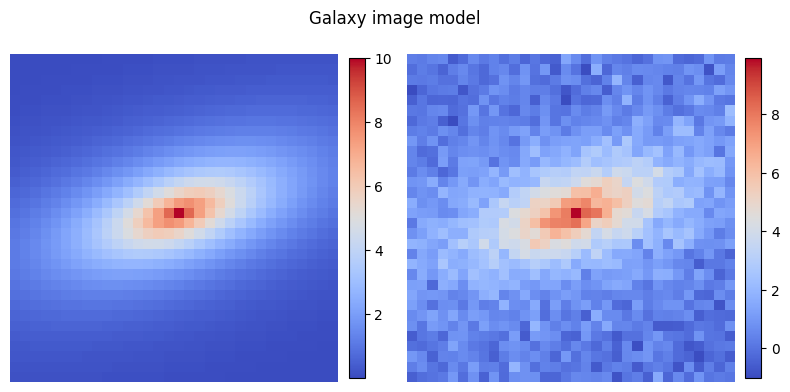

In [53]:
def elliptical_exponential_galaxy(
    key, A=1.0, a=3.0, epsilon=0.3, phi=0.0, n_pix=32, noise=False
):
    x0, y0 = n_pix // 2, n_pix // 2

    y, x = jnp.meshgrid(np.arange(n_pix), np.arange(n_pix), indexing='ij')
    dx = x - x0
    dy = y - y0

    # Convert to polar coordinates relative to center
    r = jnp.sqrt(dx ** 2. + dy ** 2.)
    varphi = jnp.arctan2(dy, dx)

    # Compute the elliptical exponential brightness
    numerator = jnp.sqrt(1. + epsilon ** 2. - 2. * epsilon * jnp.cos(2 * (varphi - phi)))
    denominator = a * jnp.sqrt(1. - epsilon ** 2.)
    mu = A * jnp.exp(-r * numerator / denominator)

    if noise:
        mu += jr.normal(key, mu.shape) * 0.05 * A

    return mu

key = jr.key(0)

img_clean = elliptical_exponential_galaxy(
    key, A=10.0, a=5.0, phi=0.3, epsilon=0.4
)
img_noisy = elliptical_exponential_galaxy(
    key, A=10.0, a=5.0, phi=0.3, epsilon=0.4, noise=True
)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Galaxy image model")

ax = axs[0]
im = ax.imshow(img_clean, origin='lower')
plt.colorbar(im, fraction=0.045, pad=0.03)

ax = axs[1]
im = ax.imshow(img_noisy, origin='lower')
plt.colorbar(im, fraction=0.045, pad=0.03)

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()

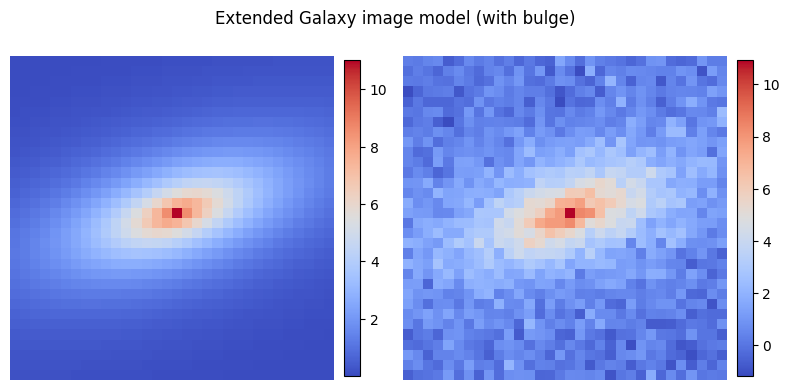

In [54]:
def elliptical_exponential_bulge_galaxy(
    key, A=1.0, a=3.0, epsilon=0.3, phi=0.0, A_b=1.0, a_b=4.0, n_pix=32, noise=False
):
    x0, y0 = n_pix // 2, n_pix // 2

    y, x = jnp.meshgrid(np.arange(n_pix), np.arange(n_pix), indexing='ij')
    dx = x - x0
    dy = y - y0

    # Convert to polar coordinates relative to center
    r = jnp.sqrt(dx ** 2. + dy ** 2.)
    varphi = jnp.arctan2(dy, dx)

    # Compute the elliptical exponential brightness
    numerator = jnp.sqrt(1. + epsilon ** 2. - 2. * epsilon * jnp.cos(2 * (varphi - phi)))
    denominator = a * jnp.sqrt(1. - epsilon ** 2.)
    mu = A * jnp.exp(-r * numerator / denominator) + A_b * jnp.exp(-a_b * r ** 2.)

    if noise:
        mu += jr.normal(key, mu.shape) * 0.05 * (A + A_b) # NOTE: is this right?

    return mu

img_clean = elliptical_exponential_bulge_galaxy(
    key, A=10.0, a=5.0, phi=0.3, epsilon=0.4, A_b=1.0, a_b=4.0
)
img_noisy = elliptical_exponential_bulge_galaxy(
    key, A=10.0, a=5.0, phi=0.3, epsilon=0.4, A_b=1.0, a_b=4.0, noise=True
)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Extended Galaxy image model (with bulge)")

ax = axs[0]
im = ax.imshow(img_clean, origin='lower')
plt.colorbar(im, fraction=0.045, pad=0.03)

ax = axs[1]
im = ax.imshow(img_noisy, origin='lower')
plt.colorbar(im, fraction=0.045, pad=0.03)

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()

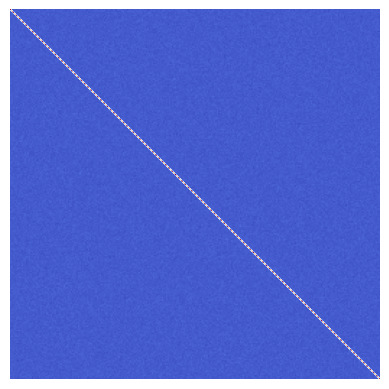

In [55]:
# Simulator function for mean, covariance and derivatives
n_pix = 16
n_d = n_pix ** 2
n_s = 10000

parameter_strings = [r"$A$", r"$a$", r"$\phi$", r"$\epsilon$"]
theta = jnp.array([10.0, 5.0, 0.3, 0.4])
parameter_strings_extended = [r"$A_b$", r"$a_b$"]
gamma = jnp.array([1.0, 4.0])
theta_gamma = jnp.concatenate([theta, gamma])

n_gamma = 5 # Number of additional extended MOPED filters

def _simulator(key, A, a, phi, epsilon):
    galaxy_image = elliptical_exponential_galaxy(
        key, A, a, phi, epsilon, n_pix=n_pix, noise=True
    )
    return galaxy_image.flatten()

def _simulator_extended(key, A, a, phi, epsilon, A_b, a_b):
    galaxy_image = elliptical_exponential_galaxy(
        key, A, a, phi, epsilon, n_pix=n_pix, noise=True
    )
    return galaxy_image.flatten()

@jax.jit
def simulator(key, params=theta):
    A, a, phi, epsilon = params
    return _simulator(key, A=A, a=a, phi=phi, epsilon=epsilon)    

@jax.jit
def simulator_extended(key, params=theta_gamma):
    A, a, phi, epsilon, A_b, a_b = params
    return _simulator_extended(key, A=A, a=a, phi=phi, epsilon=epsilon, A_b=A_b, a_b=a_b)    

keys = jr.split(key, n_s)
D_0 = jax.vmap(simulator)(keys)

covariance = jnp.cov(D_0, rowvar=False)
mu = jnp.mean(D_0, axis=0)

# Calculate derivatives
dmus = jax.vmap(jax.jacfwd(simulator, argnums=1), in_axes=(0, None))(keys, theta)
dmu = jnp.mean(dmus, axis=0).T

plt.figure()
plt.imshow(covariance)
plt.axis("off")
plt.show()

In [56]:
def linear_model(params):
    # return _simulator(None, A=A, a=a, phi=phi, epsilon=epsilon, noise=False)
    return (params - theta) @ dmu

def linear_model_extended(params):
    # return _simulator_extended(None, A=A, a=a, phi=phi, epsilon=epsilon, A_b=A_b, a_b=a_b, noise=False)    
    return (params - theta_gamma) @ dmu

### Extreme data compression while searching for new physics

#### MOPED compression 
Construct a compression from $N$ to $M$ dimensions with
$$
y_\alpha = \mathbf{b}_\alpha^T\mathbf{x}, \; \alpha = [1, M],
$$
where
$$
\mathbf{b}_1 = \frac{C^{-1}\boldsymbol{\mu}_{,1}}{\sqrt{\boldsymbol{\mu}_{,1}^TC^{-1}\boldsymbol{\mu}_{,1}}} \;
\mathbf{b}_{\alpha > 1} = \frac{C^{-1}\boldsymbol{\mu}_{,\alpha} - \sum_{\beta=1}^{\alpha-1}(\boldsymbol{\mu}^T_{,\alpha}\mathbf{b}_\beta)\mathbf{b}_\beta}{\sqrt{\boldsymbol{\mu}_{,\alpha}^TC^{-1}\boldsymbol{\mu}_{,\alpha}} - \sum_{\beta=1}^{\alpha-1}(\boldsymbol{\mu}^T_{,\alpha}\mathbf{b}_\beta)^2}.
$$
A theory $\boldsymbol{\mu}(\Theta)$ is assumed to build the MOPED filters meaning that MOPED statistics cannot be used to compare different theories. This Gram-Schmidt process orthogonalises the modes - ideally with $M\times M$ identity covariance.

Check that the Fisher information is preserved at fiducial model
compressed det F = 193542290000.0
Full.      det F = 193542290000.0


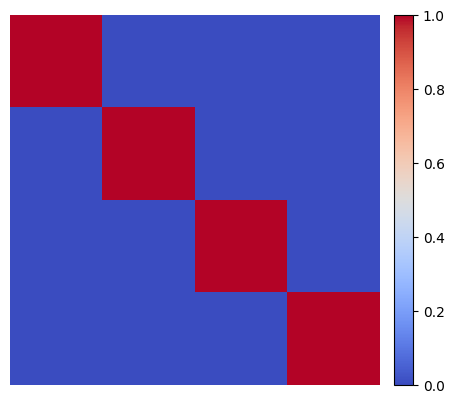

In [57]:
key = jr.key(int(time.time()))

# Compute MOPED filters 
U = np.zeros((theta.size, mu.size))
for p in range(theta.size):
    invcov_deriv = jnp.linalg.solve(covariance, dmu[p])
    if p > 0:
        coefs = U[:p, :] @ dmu[p]
        U[p,:]= (invcov_deriv - U[:p, :].T @ coefs) / jnp.sqrt(invcov_deriv @ dmu[p] - jnp.sum(coefs ** 2))
    else:
        U[p,:]= invcov_deriv / jnp.sqrt(invcov_deriv @ dmu[p])
U = jnp.asarray(U)

# Compression is linear
Y_0 = jnp.matmul(U, D_0.T).T

covariance_y = jnp.cov(Y_0, rowvar=False)

# Confirm that Fisher information is conserved
F_y = np.zeros((theta.size, theta.size))
for i in range(theta.size):
    for j in range(theta.size):
        F_y[i, j] = (U @ dmu[i]).T @ jnp.linalg.solve(covariance_y, U @ dmu[j])
F_y = jnp.asarray(F_y)
Finv_y = jnp.linalg.inv(F_y)

F_d = np.zeros((theta.size, theta.size))
for i in range(theta.size):
    for j in range(theta.size):
        F_d[i,j] = dmu[i].T @ jnp.linalg.solve(covariance, dmu[j])
F_d = jnp.asarray(F_d)
Finv_d = jnp.linalg.inv(F_d)

print("Check that the Fisher information is preserved at fiducial model")
print("compressed det F = " + str(jnp.linalg.det(F_y)))
print("Full.      det F = " + str(jnp.linalg.det(F_d)))

# Confirm that covmat is diagonalized 
plt.imshow(covariance_y)
plt.colorbar(fraction=0.05, pad=0.03)
plt.axis("off")
plt.show()

In [58]:
def moped(d):
    return jnp.matmul(U, d)

def get_X(x):
    dx = x - linear_model(theta)
    X = dx - sum(moped(dx)[p] * covariance @ U[p].T for p in range(theta.size))
    return X

# Measurement simulated with extended physical model
x = simulator_extended(key, theta_gamma) 

# Generate a set of measurements to estimate the covariance of X, even though it is known analytically
keys = jr.split(key, n_s)
x_set = jax.vmap(simulator_extended, in_axes=(0, None))(keys, theta_gamma)
X_set = jax.vmap(get_X)(x_set)
covariance_X = jnp.cov(X_set, rowvar=False)

L = jnp.linalg.cholesky(covariance)
Linv = jnp.linalg.inv(L)
A = Linv @ covariance_X @ Linv.T

Lambdas, vs = jnp.linalg.eigh(A)

us = jax.vmap(lambda v_gamma: jnp.linalg.solve(Linv.T, v_gamma))(vs)

# Filter by non-zero eigenvalues
nonzero_eig_mask = jnp.abs(Lambdas) > 1e-6
Lambdas_nonzero = Lambdas[nonzero_eig_mask] # First two are Moped modes?!
us_nonzero = us[:, nonzero_eig_mask].T # Tranpose to same shape as Moped filters

print(U.shape, us_nonzero.shape)

U_extended = jnp.concatenate([U, us_nonzero])

(4, 256) (252, 256)


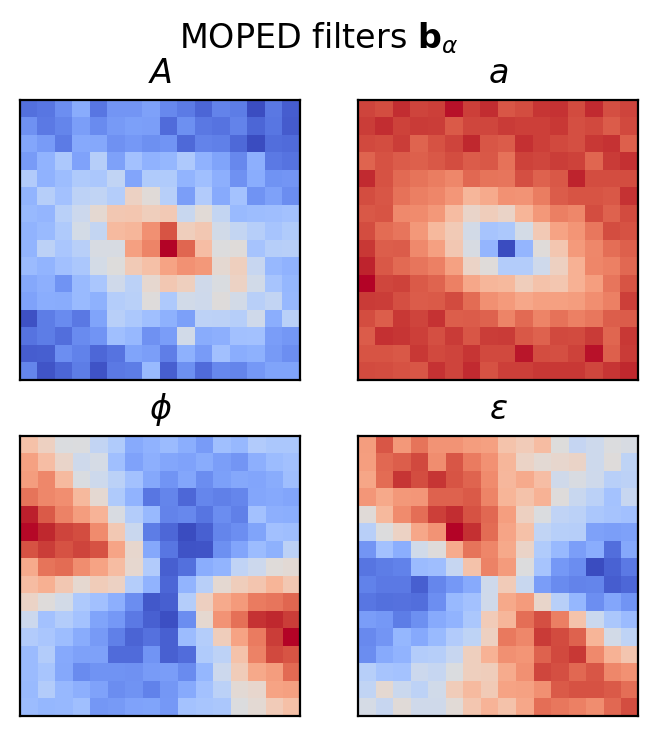

In [59]:
fig, axs = plt.subplots(2, 2, dpi=200, figsize=(4., 4.))
fig.suptitle(r"MOPED filters $\mathbf{b}_\alpha$")
for b, ax, parameter_name in zip(U, axs.ravel(), parameter_strings):
    ax.set_title(parameter_name)
    ax.imshow(b.reshape(n_pix, n_pix))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

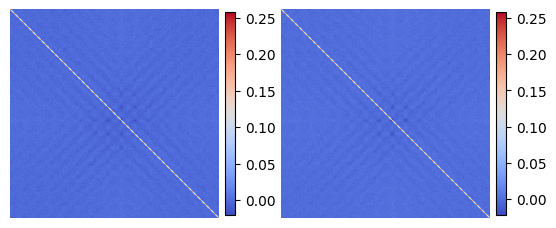

In [60]:
# Calculate analytic covariance of X and compare to simulated
covariance_X_ = np.zeros((n_d, n_d))
for i in range(n_d):
  for j in range(n_d):
    term = sum(
        (covariance @ U[p])[i] * (covariance @ U[p])[j]
        for p in range(theta.size)
    )
    covariance_X_[i, j] = covariance[i, j] - term

fig, axs = plt.subplots(1, 2)
ax = axs[0]
im = ax.imshow(covariance_X_)
plt.colorbar(im, fraction=0.045, pad=0.03)
ax.axis("off")
ax = axs[1]
im = ax.imshow(covariance_X)
plt.colorbar(im, fraction=0.045, pad=0.03)
ax.axis("off")
plt.show()

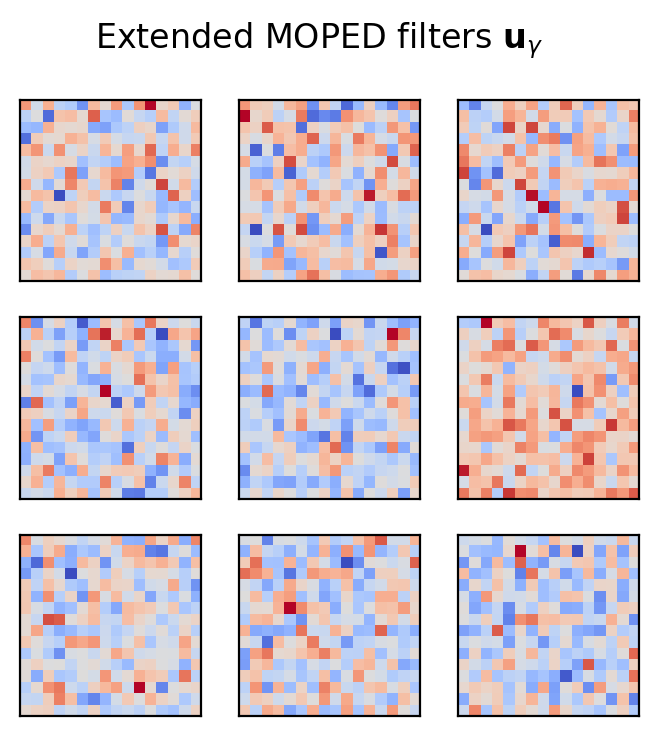

In [61]:
n_side = int(np.sqrt(n_gamma)) + 1

fig, axs = plt.subplots(n_side, n_side, dpi=200, figsize=(4., 4.))
fig.suptitle(r"Extended MOPED filters $\mathbf{u}_\gamma$")

for i, ax in enumerate(axs.ravel()):
    # ax.set_title(r"$\gamma_{}$".format(i))
    ax.imshow(U_extended[theta.size + i].reshape(n_pix, n_pix)) # Skip theta filters

for ax in axs.ravel():
    ax.set_xticks([]) 
    ax.set_yticks([])

plt.show()

(10000, 4) (10000, 9)


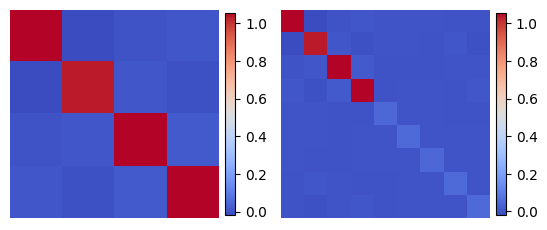

In [62]:
def moped_extended(d, alpha=n_gamma):
    # f_alpha = b_alpha if alpha in 1,...,M OR u_alpha if alpha in [M + 1, N]
    n_modes = min(theta.size + alpha, n_d)
    return jnp.matmul(U_extended, d - linear_model(theta))[:n_modes]

y_moped = jax.vmap(moped)(x_set)
y_moped_extended = jax.vmap(moped_extended)(x_set)

print(y_moped.shape, y_moped_extended.shape)

cov_y_moped = jnp.cov(y_moped, rowvar=False) 
cov_y_moped_extended = jnp.cov(y_moped_extended, rowvar=False)

fig, axs = plt.subplots(1, 2)
ax = axs[0]
im = ax.imshow(cov_y_moped)
plt.colorbar(im, fraction=0.045, pad=0.03)
ax = axs[1]
im = ax.imshow(cov_y_moped_extended)
plt.colorbar(im, fraction=0.045, pad=0.03)
for ax in axs: 
    ax.axis("off")
plt.show()

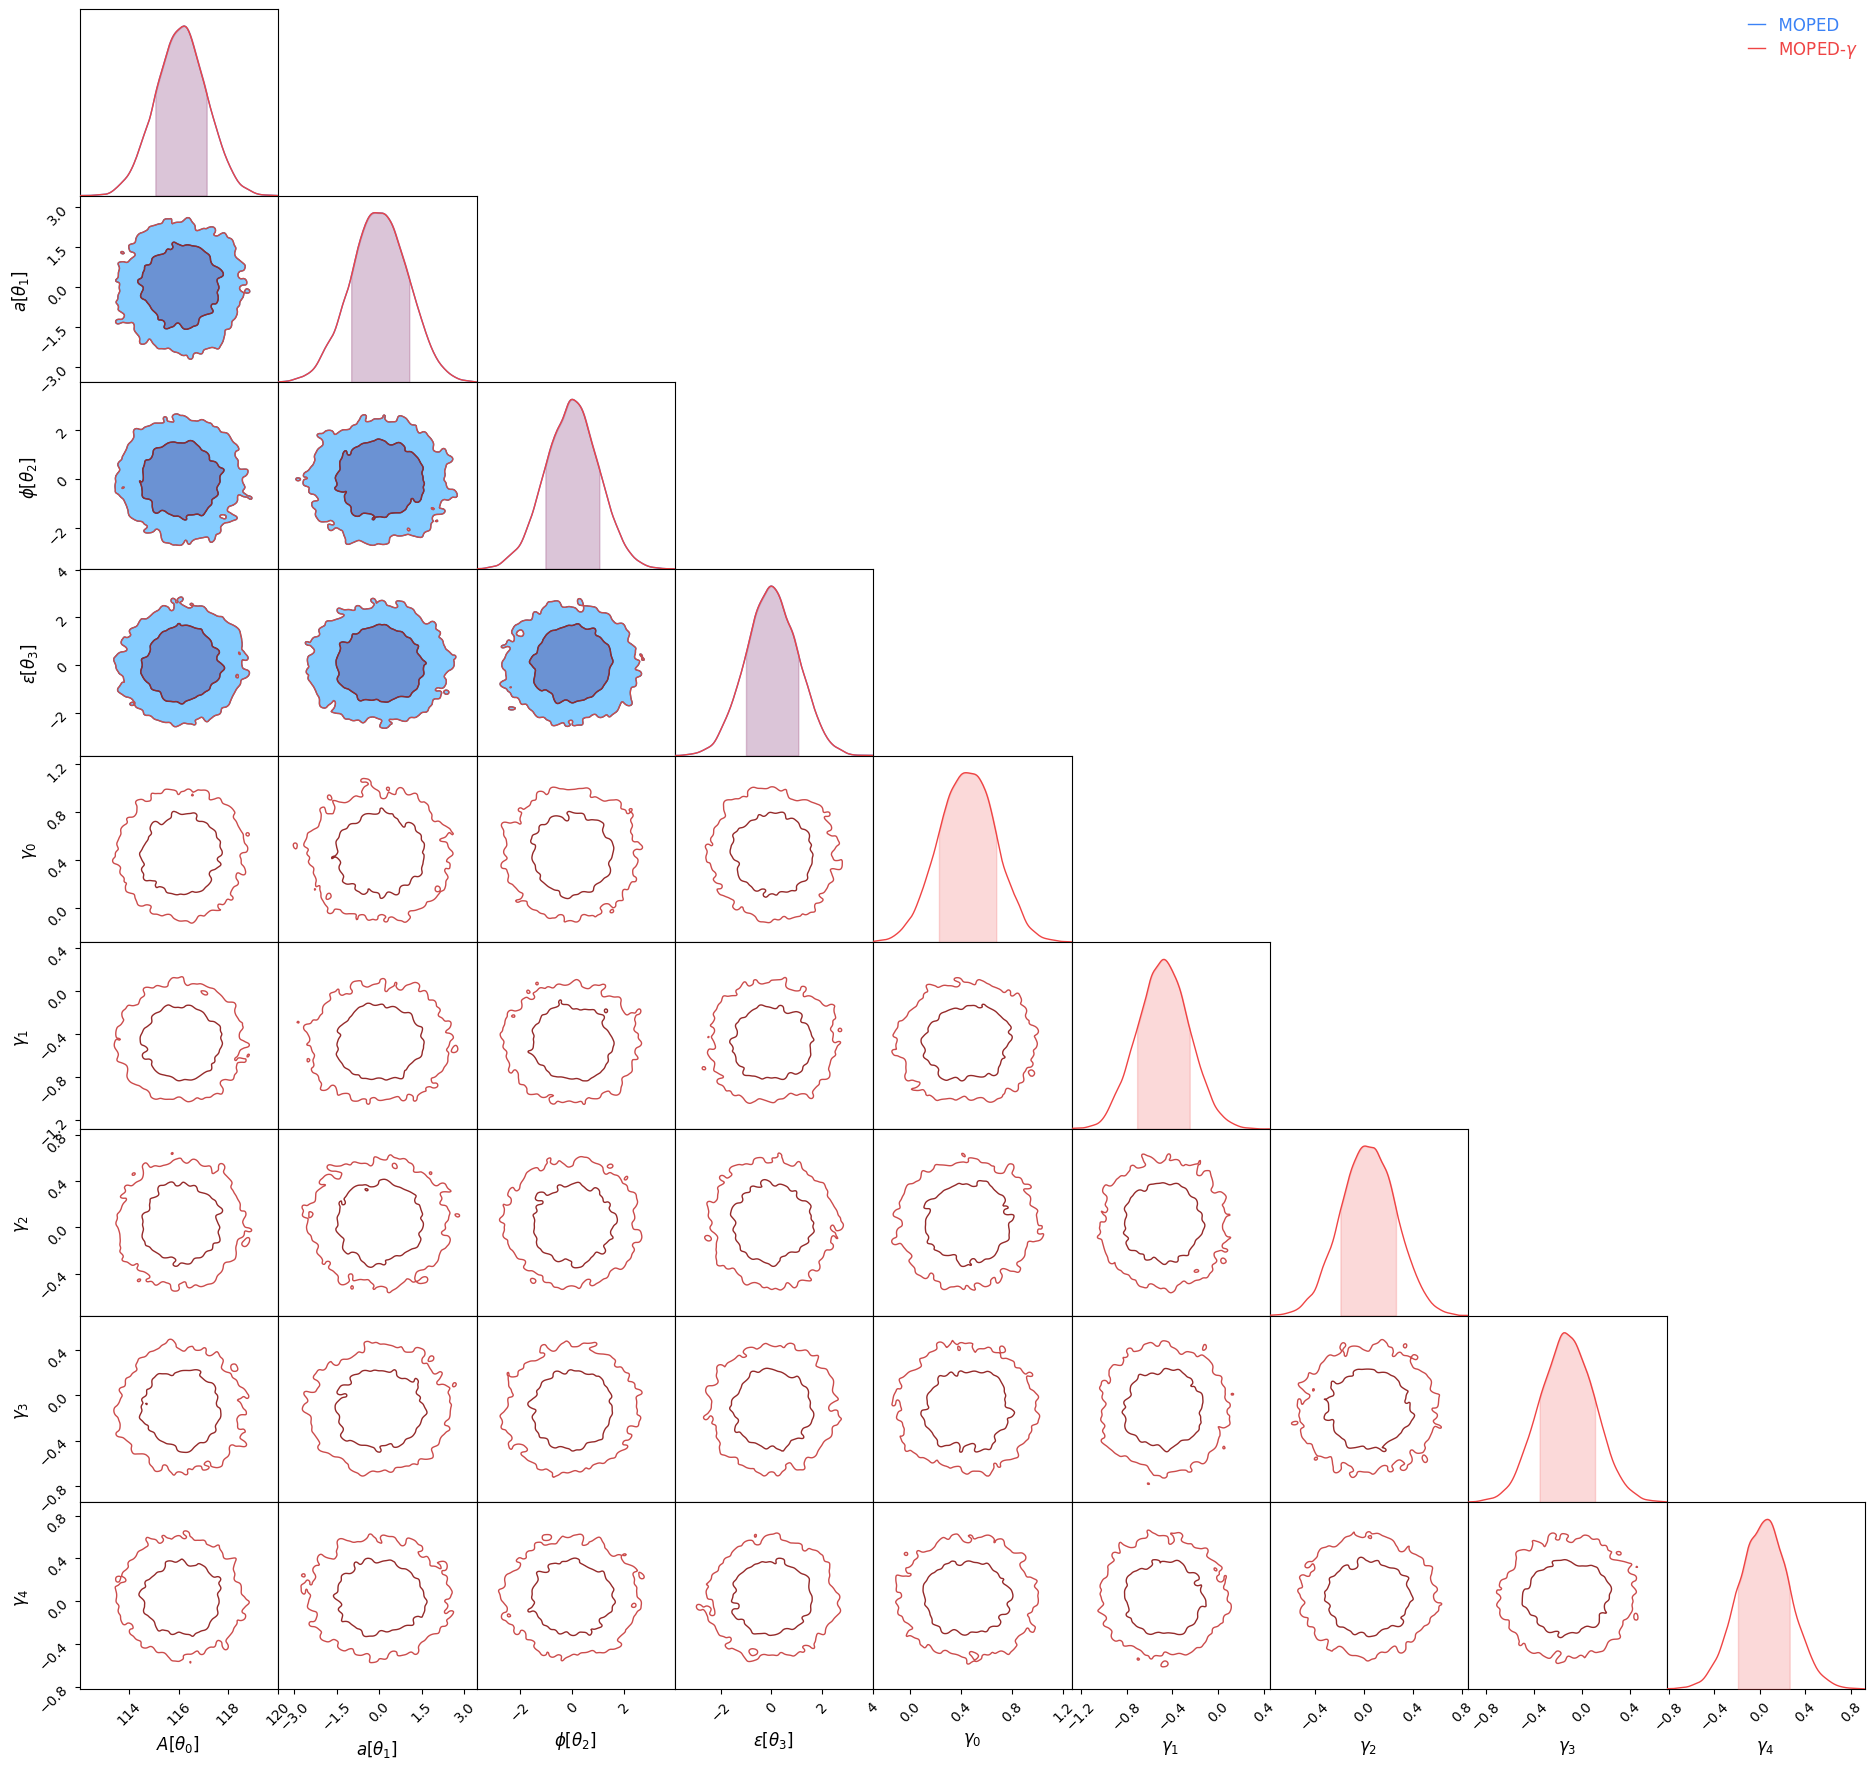

In [67]:
from chainconsumer import Chain, ChainConfig, ChainConsumer, PlotConfig, Truth, make_sample
import pandas as pd

parameter_strings_theta = [r"{}[$\theta_{}$]".format(parameter_strings[m], m) for m in range(theta.size)]
# parameter_strings_gamma = [r"{}[$\gamma_{}$]".format(parameter_strings_extended[n], n) for n in range(gamma.size)]
parameter_strings_gamma = [r"$\gamma_{}$".format(n) for n in range(n_gamma)]

def make_df(y, parameter_strings, log_probs=None):
    df = pd.DataFrame(
        np.asarray(y), columns=parameter_strings
    ).assign(log_posterior=np.ones((len(y),)) if log_probs is None else log_probs)
    return df

c = ChainConsumer()
c.add_chain(
    Chain(
        samples=make_df(y_moped_extended[:, :theta.size], parameter_strings_theta), 
        name="MOPED", shade=True, color="blue"
    )
)
c.add_chain(
    Chain(
        samples=make_df(y_moped_extended, parameter_strings_theta + parameter_strings_gamma), 
        name=r"MOPED-$\gamma$", shade=False, color="red"
    )
)
# c.add_truth(
#     Truth(
#         location=dict(zip(parameter_strings_theta, np.asarray(theta))),
#         color="blue"
#     )
# )
# c.add_truth(
#     Truth(
#         location=dict(zip(parameter_strings_gamma, np.asarray(gamma))),
#         color="red"
#     )
# )
# c.add_chain(
#     Chain.from_covariance(
#         theta,
#         Finv_y,
#         columns=parameter_strings_theta,
#         name="$F^{-1}_d$",
#         color="k",
#         linestyle=":",
#     )
# )
fig = c.plotter.plot()

In [64]:
import operator 
import jax
import jax.numpy as jnp


def random_split_like_tree(rng_key, target=None, treedef=None):
    if treedef is None: treedef = jax.tree_util.tree_structure(target)
    keys = jax.random.split(rng_key, treedef.num_leaves)
    return jax.tree.unflatten(treedef, keys)


def normal_like_tree(rng_key, target, mean=0, std=1):
    # https://github.com/google/jax/discussions/9508#discussioncomment-2144076
    keys_tree = random_split_like_tree(rng_key, target)
    return jax.tree.map(lambda l, k: mean + std*jax.random.normal(k, l.shape, l.dtype), target, keys_tree)


def ifelse(cond, val_true, val_false):
    return jax.lax.cond(cond, lambda x: x[0], lambda x: x[1], (val_true, val_false))


def leapfrog(params, momentum, log_prob_fn, step_size, n_steps):
    """ Approximates Hamiltonian dynamics using the leapfrog algorithm. """

    def step(i, args):
        params, momentum = args

        # Update momentum
        grad = jax.grad(log_prob_fn)(params)
        momentum = jax.tree.map(lambda m, g: m + 0.5 * step_size * g, momentum, grad)

        # Update params
        params = jax.tree.map(lambda p, m: p + m * step_size, params, momentum)

        # Update momentum
        grad = jax.grad(log_prob_fn)(params)
        momentum = jax.tree.map(lambda m, g: m + 0.5 * step_size * g, momentum, grad)

        return params, momentum

    # Do 'n_steps'
    new_params, new_momentum = jax.lax.fori_loop(0, n_steps, step, (params, momentum))

    return new_params, new_momentum


def sample(key, params_init, log_prob_fn, n_steps, n_leapfrog_steps, step_size):
    """
    Runs HMC and returns the full Markov chain as a Pytree.
    - params: array
    - log_prob_fn: function that takes params as the only argument and returns a scalar value
    """

    # define a single step
    def step_fn(carry, x):
        params, key = carry
        key, normal_key, uniform_key = jax.random.split(key, 3)

        # generate random momentum
        momentum = normal_like_tree(key, params)

        # leapfrog
        new_params, new_momentum = leapfrog(params, momentum, log_prob_fn, step_size, n_leapfrog_steps)

        # MH correction
        potentaial_energy_diff = log_prob_fn(new_params) - log_prob_fn(params)
        momentum_dot = jax.tree.reduce(
            operator.add, tree_map(lambda x: (x**2).sum(), tree_leaves(momentum))
        )
        new_momentum_dot = jax.tree.reduce(
            operator.add, tree_map(lambda x: (x**2).sum(), tree_leaves(new_momentum))
        )
        kinetic_energy_diff = 0.5 * (momentum_dot - new_momentum_dot)
        log_accept_prob = potentaial_energy_diff + kinetic_energy_diff
        log_accept_prob = jnp.nan_to_num(log_accept_prob, nan=-jnp.inf)
        accept_prob = jnp.minimum(1, jnp.exp(log_accept_prob))
        accept = jax.random.uniform(uniform_key) < accept_prob
        params = ifelse(accept, new_params, params)

        return (params, key), (params, accept_prob)

    # do 'n_steps'
    _, (chain, accept_prob) = jax.lax.scan(step_fn, (params_init, key), xs=None, length=n_steps)
    
    # print(f'accept={accept_prob.mean():.2%}')
    return chain

In [ ]:
from functools import partial
import jax.scipy.stats as jss

# alpha is number of modes from extended MOPED to use
n_theta = theta.size

def linear_model_gamma(theta, gamma):
    # theta, gamma = jnp.split(params, [theta.size])
    u_gammas = U_extended[:, :n_gamma]
    print(u_gammas.shape, (covariance @ u_gammas).shape)
    return linear_model(theta) + gamma * (covariance @ u_gammas).T

def likelihood(d, theta, gamma, alpha=n_gamma):
    y = moped_extended(d, alpha=alpha)
    u_gammas = U_extended[:, :n_gamma]
    mean = (u_gammas @ (linear_model_gamma(theta, gamma) - linear_model(theta)))[:theta.size + alpha]
    cov = jnp.eye(alpha + theta.size)
    L = jss.multivariate_normal.logpdf(y, mean=mean, cov=cov)
    return L

def log_prob_fn(params, d):
    theta, gamma = jnp.split(params, [n_theta])
    return likelihood(d, theta, gamma)

n_posterior_samples = 1_000
params_init = jnp.zeros((n_posterior_samples, theta.size + n_gamma,))
datavector = D_0[0]
sampler_fn = lambda key, params_init: sample(
    key, 
    params_init, 
    partial(log_prob_fn, d=datavector),
    n_steps=100, 
    n_leapfrog_steps=100, 
    step_size=0.1
)
keys = jr.split(key, n_posterior_samples)
chain = jax.vmap(sampler_fn)(keys, params_init)[:, -1, :]

log_probs = jax.vmap(lambda params: log_prob_fn(params, datavector))(chain)

In [ ]:
from chainconsumer import Chain, ChainConfig, ChainConsumer, PlotConfig, Truth, make_sample
import pandas as pd

parameter_strings_theta = [r"$\theta_{}$".format(m) for m in range(theta.size)]
parameter_strings_gamma = [r"$\gamma_{}$".format(n) for n in range(gamma.size)]


c = ChainConsumer()
c.add_chain(
    Chain(
        samples=make_df(chain, parameter_strings_theta + parameter_strings_gamma, log_probs=log_probs), 
        name="MOPED", shade=True, color="blue"
    )
)
c.add_truth(
    Truth(
        location=dict(zip(parameter_strings_theta, np.asarray(theta))),
        color="blue"
    )
)
c.add_truth(
    Truth(
        location=dict(zip(parameter_strings_gamma, np.asarray(gamma))),
        color="red"
    )
)
# c.add_chain(
#     Chain.from_covariance(
#         theta,
#         Finv_y,
#         columns=parameter_strings_theta,
#         name="$F^{-1}_d$",
#         color="k",
#         linestyle=":",
#     )
# )
fig = c.plotter.plot()